In [1]:
import os
import numpy as np
from PIL import Image
import torch as ns
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import evaluate
import pytorch_lightning as pl
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import matplotlib.pyplot as plt
from transformers import SegformerFeatureExtractor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import multiprocessing
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim import AdamW 
import torch.optim as optim
from pytorch_lightning.loggers import WandbLogger
import wandb
import time

c:\Users\DSBG-Public\.conda\envs\Seg-Rob\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\DSBG-Public\.conda\envs\Seg-Rob\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\DSBG-Public\.conda\envs\Seg-Rob\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according

In [2]:
wandb.login()

project_name = f"segformer_{time.strftime('%Y%m%d_%H%M%S')}"



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: diego-gonca-simao (diego-gonca-simao-basel) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:

# === Configurations ===
TRAIN_IMAGE_DIR = 'C:/Users/DSBG-Public/segformer/dataset/train/images'
TRAIN_MASK_DIR = 'C:/Users/DSBG-Public/segformer/dataset/train/masks'
VAL_IMAGE_DIR = 'C:/Users/DSBG-Public/segformer/dataset/val/images'
VAL_MASK_DIR = 'C:/Users/DSBG-Public/segformer/dataset/val/masks'
TEST_IMAGE_DIR = 'C:/Users/DSBG-Public/segformer/dataset/test/images'
TEST_MASK_DIR = 'C:/Users/DSBG-Public/segformer/dataset/test/masks'
NUM_CLASSES = 2

# === Dataset ===
class SemanticSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, feature_extractor, resize=(512, 512)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.resize = resize
        self.feature_extractor = feature_extractor
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_dir, self.images[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, self.masks[idx])).convert("L")
        image = image.resize(self.resize)
        mask = mask.resize(self.resize)
        
        encoding = self.feature_extractor(images=image, return_tensors="pt")
        pixel_values = encoding['pixel_values'].squeeze(0)
        
        mask = np.array(mask)
        mask = (mask > 127).astype(np.uint8)
        mask = np.clip(mask, 0, NUM_CLASSES - 1)
        mask = ns.tensor(mask, dtype=ns.long)

        train_tf = A.Compose(
        [A.HorizontalFlip(), A.RandomRotate90(),
        A.ColorJitter(0.2,0.2,0.2,0.1),
        A.GaussianBlur(p=0.2), 
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(), ToTensorV2()],
        additional_targets={'mask':'mask'}
        )

        val_tf = A.Compose([A.Normalize(), ToTensorV2()],
                   additional_targets={'mask':'mask'})
        
        encoding['labels'] = mask
        encoding['pixel_values'] = pixel_values
        return encoding
    

class DiceLoss(nn.Module):
    def forward(self, logits, targets, eps=1e-6):
        probs = logits.softmax(1)
        targets_oh = nn.functional.one_hot(targets, num_classes=NUM_CLASSES).permute(0,3,1,2)
        inter = (probs*targets_oh).sum((2,3))
        union = probs.sum((2,3)) + targets_oh.sum((2,3))
        dice = 1 - (2*inter + eps)/(union + eps)
        return dice.mean()

dice_loss = DiceLoss()
ce_loss   = nn.CrossEntropyLoss()


# === PyTorch Lightning Module ===
class SegformerFinetuner(pl.LightningModule):

    def __init__(self, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=50):
        super(SegformerFinetuner, self).__init__()
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader

        self.num_classes = NUM_CLASSES 

        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512", 
            return_dict=False, 
            num_labels=self.num_classes,
            ignore_mismatched_sizes=True,
        )

        self.train_mean_iou = evaluate.load("mean_iou")
        self.val_mean_iou = evaluate.load("mean_iou")
        self.test_mean_iou = evaluate.load("mean_iou")


    def forward(self, images, masks):
        return self.model(pixel_values=images, labels=masks)
    
    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        pixel_values = batch["pixel_values"]
        outputs = self.model(pixel_values, labels)
        loss_ce, logits = outputs[:2]
        
        
        # Resize labels to match logits spatial dimensions if necessary.
        upsampled_logits = F.interpolate(
            logits, 
            size=labels.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        loss = 0.5*loss_ce + 0.5*dice_loss(upsampled_logits, labels)

        predicted = upsampled_logits.argmax(dim=1)

        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=labels.detach().cpu().numpy()
        )
        if batch_idx % self.metrics_interval == 0:

            metrics = self.train_mean_iou.compute(
                num_labels=self.num_classes, 
                ignore_index=255, 
                reduce_labels=False,
            )
            
            metrics = {'loss': loss, "mean_iou": metrics["mean_iou"], "mean_accuracy": metrics["mean_accuracy"]}
            self.log("train_loss",    loss,    prog_bar=True)          # prints + sends to W&B
            self.log("train_mIoU",    metrics["mean_iou"], prog_bar=True)
            self.log("train_acc",     metrics["mean_accuracy"], prog_bar=True)
            for k,v in metrics.items():
                self.log(k,v)
            
            return(metrics)
        else:
            return({'loss': loss})
    
    def validation_step(self, batch, batch_idx):
        labels = batch["labels"]
        pixel_values = batch["pixel_values"]
        outputs = self.model(pixel_values,labels)
        loss_ce, logits = outputs[:2]
        
        upsampled_logits = F.interpolate(
            logits, 
            size=labels.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        loss = 0.5*loss_ce + 0.5*dice_loss(upsampled_logits, labels)
        predicted = upsampled_logits.argmax(dim=1)
        
        self.val_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=labels.detach().cpu().numpy()
        )
        self.log("val_loss", loss)
        return({'val_loss': loss})

    
    def test_step(self, batch, batch_idx):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = F.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        self.log("test_loss", loss)
        return({'test_loss': loss})
    
    def configure_optimizers(self):
       optimizer = optim.AdamW(self.parameters(), lr=6e-5, weight_decay=0.01)
       steps_per_epoch = len(self.train_dl)
       max_iters = self.trainer.max_epochs * steps_per_epoch
       scheduler = optim.lr_scheduler.LambdaLR(
            optimizer, lr_lambda=lambda it: (1 - it / float(max_iters)) ** 0.9)
       return {
            "optimizer": optimizer,
              "lr_scheduler": {"scheduler": scheduler, "interval": "step"}
                }
    def train_dataloader(self):
        return self.train_dl
    
    def val_dataloader(self):
        return self.val_dl
    
    def test_dataloader(self):
        return self.test_dl

In [4]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.reduce_labels = False

train_dataset = SemanticSegmentationDataset(TRAIN_IMAGE_DIR,TRAIN_MASK_DIR, feature_extractor)
val_dataset = SemanticSegmentationDataset(VAL_IMAGE_DIR,VAL_MASK_DIR, feature_extractor)
test_dataset = SemanticSegmentationDataset(TEST_IMAGE_DIR,TEST_MASK_DIR, feature_extractor)

batch_size = 12
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

segformer_finetuner = SegformerFinetuner(
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    test_dataloader=test_dataloader, 
    metrics_interval=10,
)

checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="loss")

wandb_logger = WandbLogger(
    project=project_name,
    name="b0_dice_ce",         
    log_model=True
)    

trainer = pl.Trainer(
    max_epochs=40,
    precision=16,
    accumulate_grad_batches=2,
    logger=wandb_logger,  
    check_val_every_n_epoch=1,
    callbacks=[
        checkpoint_callback
    ],
    enable_progress_bar=True 
)

trainer.fit(segformer_finetuner)


c:\Users\DSBG-Public\.conda\envs\Seg-Rob\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
c:\Users\DSBG-Public\.conda\envs\Seg-Rob\lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.S

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                             | Params | Mode
------------------------------------------------------------------
0 | model | SegformerForSemanticSegmentation | 3.7 M  | eval
------------------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.859    Total estimated model params size (MB)
0         Modules in train mode
213       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\DSBG-Public\.conda\envs\Seg-Rob\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.00it/s]

c:\Users\DSBG-Public\.conda\envs\Seg-Rob\lib\site-packages\datasets\features\image.py:347: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


c:\Users\DSBG-Public\.conda\envs\Seg-Rob\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
c:\Users\DSBG-Public\.conda\envs\Seg-Rob\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 26/26 [00:24<00:00,  1.07it/s, v_num=ieki, train_loss=0.0217, train_mIoU=0.968, train_acc=0.984]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 26/26 [00:24<00:00,  1.07it/s, v_num=ieki, train_loss=0.0217, train_mIoU=0.968, train_acc=0.984]


In [5]:
res = trainer.test(ckpt_path="best")

Restoring states from the checkpoint path at .\segformer_20250422_144904\he6aieki\checkpoints\epoch=36-step=481.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at .\segformer_20250422_144904\he6aieki\checkpoints\epoch=36-step=481.ckpt
c:\Users\DSBG-Public\.conda\envs\Seg-Rob\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.29589325189590454    │
└───────────────────────────┴───────────────────────────┘

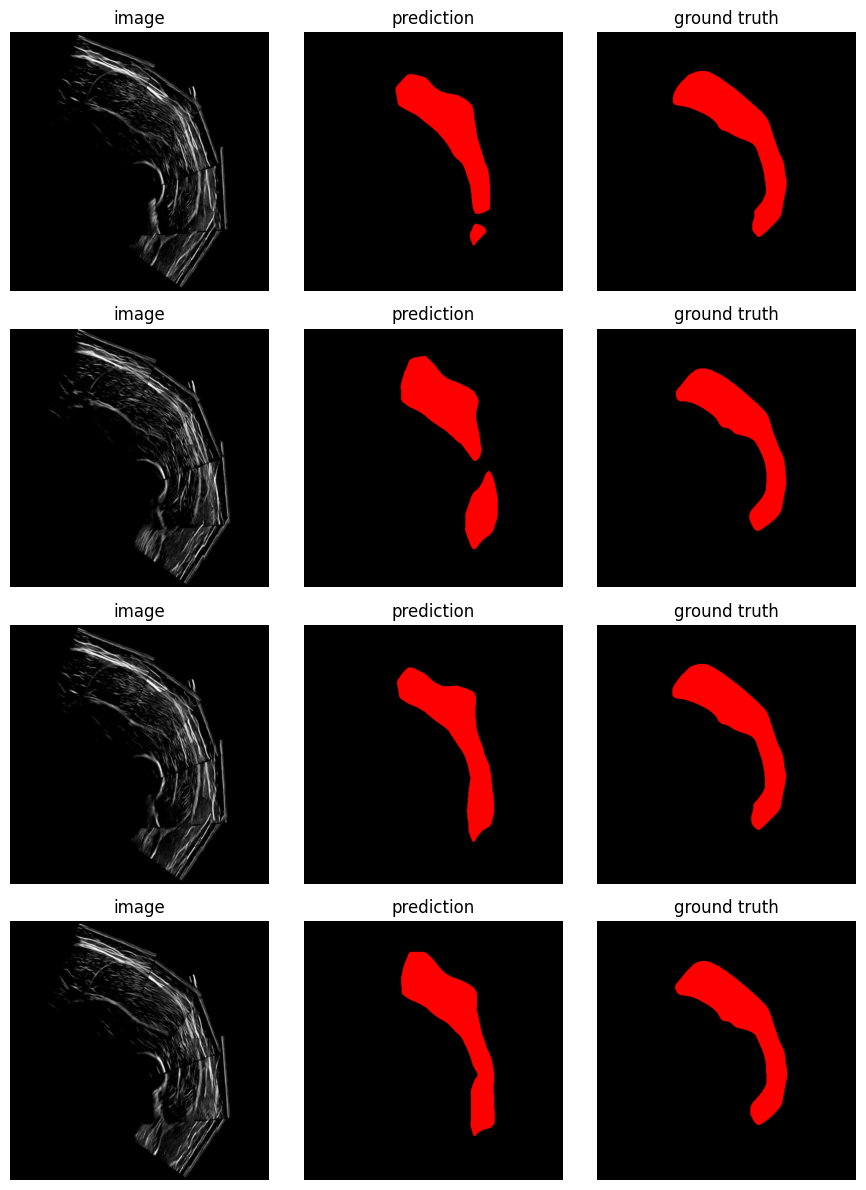

In [8]:
import torch            # 1️⃣ make sure torch is imported
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import random, itertools

# ─── colour palette ──────────────────────────────────────────────
color_map = {0: (0, 0, 0),         # background  → black
             1: (255, 0, 0)}       # object      → red

def to_rgb(mask: torch.Tensor | np.ndarray) -> np.ndarray:
    """Class‑index mask → H×W×3 RGB image."""
    mask = mask.cpu().numpy()          # work on numpy
    rgb  = np.zeros(mask.shape + (3,), dtype=np.uint8)
    for cls, col in color_map.items():
        rgb[mask == cls] = col
    return rgb

# ─── get one test batch ──────────────────────────────────────────
rand_batch_idx = random.randrange(len(test_dataloader))
batch = next(itertools.islice(test_dataloader, rand_batch_idx, None))   
images = batch["pixel_values"]             
masks  = batch["labels"]  # CHW tensors, on CPU

def denorm(t: torch.Tensor) -> np.ndarray:
    """Undo (x‑mean)/std → 0‑1 float array ready for imshow."""
    x = (t * std + mean).clamp(0, 1)        # CHW tensor, 0‑1
    return x.permute(1, 2, 0).cpu().numpy() # → HWC

mean = torch.tensor(feature_extractor.image_mean).view(3, 1, 1)
std  = torch.tensor(feature_extractor.image_std).view(3, 1, 1)

with torch.no_grad():                         # 2️⃣ torch.no_grad, not ns.no_grad
    _, logits = segformer_finetuner.model(images, masks)

# up‑sample 128×128 logits → 512×512, then argmax → predicted mask
logits = torch.nn.functional.interpolate(
            logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
pred = logits.argmax(dim=1)                   # shape: B×H×W

# ─── visualise first n samples ───────────────────────────────────
k = 4                     # 3️⃣ safe slice
sel = random.sample(range(images.size(0)), k)

plt.figure(figsize=(9, 3*k))
for i, idx in enumerate(sel):
    plt.subplot(k,3,3*i+1); plt.imshow(denorm(images[idx]));     plt.title("image");       plt.axis("off")
    plt.subplot(k,3,3*i+2); plt.imshow(to_rgb(pred[idx].cpu())); plt.title("prediction");  plt.axis("off")
    plt.subplot(k,3,3*i+3); plt.imshow(to_rgb(masks[idx].cpu()));plt.title("ground truth");plt.axis("off")

plt.tight_layout(); plt.show()
